In [1]:
from pathlib import Path
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root=Path().cwd().parent / "datasets", name="Cora", transform=NormalizeFeatures())

print(f"Dataset: {dataset}, Number of graphs: {len(dataset)}, Number of features: {dataset.num_features}")

Dataset: Cora(), Number of graphs: 1, Number of features: 1433


In [3]:
graph = dataset[0]
print(graph)
print(f"num nodes: {graph.num_nodes}, num edges: {graph.num_edges}")
print(f"num features {graph.num_features}")
print(f"Node label | Train: {graph.train_mask.sum()} | Valid: {graph.val_mask.sum()}, Test: {graph.test_mask.sum()}")
print(f"Has isolated nodes: {graph.has_isolated_nodes()}, Has self-loops: {graph.has_self_loops()}")

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
num nodes: 2708, num edges: 10556
num features 1433
Node label | Train: 140 | Valid: 500, Test: 1000
Has isolated nodes: False, Has self-loops: False


In [4]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super().__init__()
        torch.manual_seed(0)
        self.lin1 = Linear(num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index=None):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(dataset.num_features, 32, dataset.num_classes)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=7, bias=True)
)


In [5]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

def train(model: torch.nn.Module):
    model.train()
    optimizer.zero_grad()
    out = model(graph.x, graph.edge_index)
    loss =  criterion(out[graph.train_mask], graph.y[graph.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test(model: torch.nn.Module):
    model.eval()
    out = model(graph.x, graph.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[graph.test_mask] == graph.y[graph.test_mask]
    test_acc = int(test_correct.sum()) / int(graph.test_mask.sum())
    return test_acc

for epoch in range(1, 201):
    loss = train(model)
    if epoch % 50 == 0:
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}")

Epoch: 050, Loss: 1.8988
Epoch: 100, Loss: 1.7779
Epoch: 150, Loss: 1.5855
Epoch: 200, Loss: 1.3799


In [6]:
test_acc = test(model)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.4940


In [7]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super().__init__()
        torch.manual_seed(0)
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(dataset.num_features, 32, dataset.num_classes)
print(model)

GCN(
  (conv1): GCNConv(1433, 32)
  (conv2): GCNConv(32, 7)
)


In [9]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(1, 201):
    loss = train(model)
    if epoch % 50 == 0:
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}")

Epoch: 050, Loss: 0.9721
Epoch: 100, Loss: 0.7956
Epoch: 150, Loss: 0.6300
Epoch: 200, Loss: 0.5281


In [10]:
test_acc = test(model)
print(f"Test Accuracy: {test_acc}")

Test Accuracy: 0.807


/home/yoshiakira/.conda/envs/grl/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/yoshiakira/.conda/envs/grl/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


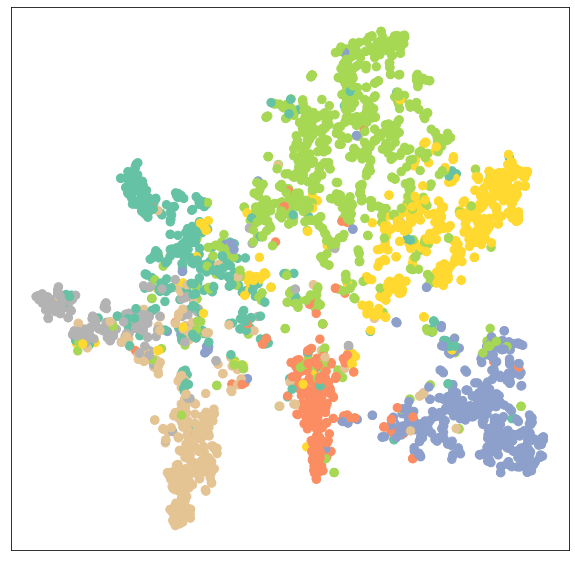

In [11]:
model.eval()
out = model(graph.x, graph.edge_index)
visualize(out, color=graph.y)

In [17]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, num_features, num_hidden, num_classes):
        super().__init__()
        torch.manual_seed(0)
        self.conv1 = GATConv(num_features, num_hidden, heads=8)
        self.conv2 = GATConv(num_hidden * 8, num_classes, heads=1)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(dataset.num_features, 32, dataset.num_classes)
print(model)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 201):
    loss = train(model)
    if epoch % 50 == 0:
        test_acc = test(model)
        print(f"Epoch: {epoch:04d}, Loss: {loss:.4f}, Test Acc: {test_acc:.4f}")

GAT(
  (conv1): GATConv(1433, 32, heads=8)
  (conv2): GATConv(256, 7, heads=1)
)
Epoch: 0050, Loss: 1.6495, Test Acc: 0.7970
Epoch: 0100, Loss: 1.0192, Test Acc: 0.8100
Epoch: 0150, Loss: 0.5257, Test Acc: 0.8070
Epoch: 0200, Loss: 0.2811, Test Acc: 0.8070


In [18]:
test_acc = test(model)
print(f"Test Accuracy: {test_acc}")

Test Accuracy: 0.807


/home/yoshiakira/.conda/envs/grl/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/yoshiakira/.conda/envs/grl/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


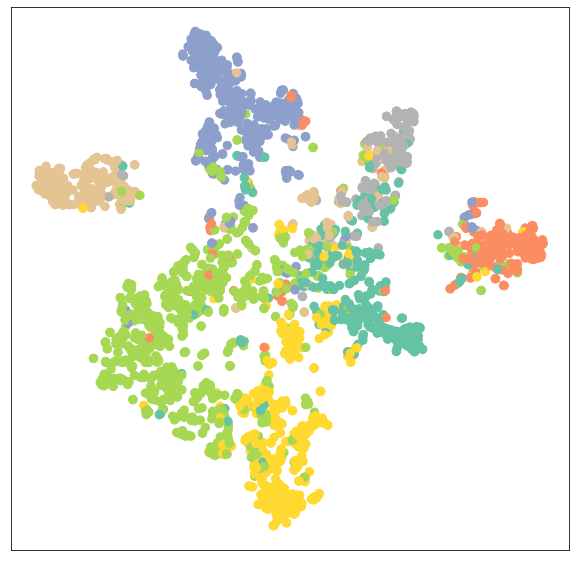

In [19]:
model.eval()
out = model(graph.x, graph.edge_index)
visualize(out, color=graph.y)